In [ ]:
import pandas as pd
import numpy as np

# import data to pandas database
synth1 = pd.read_csv('data\synthetic-1.csv', header= 0)
synth2 = pd.read_csv('data\synthetic-2.csv', header= 0)
synth3 = pd.read_csv('data\synthetic-3.csv', header= 0)
synth4 = pd.read_csv('data\synthetic-4.csv', header= 0 )

# set column titles
synth1.columns = ['Feature1', 'Feature2', 'ClassLabel']
synth2.columns = ['Feature1', 'Feature2', 'ClassLabel']
synth3.columns = ['Feature1', 'Feature2', 'ClassLabel']
synth4.columns = ['Feature1', 'Feature2', 'ClassLabel']

# append datasets together
synthMerge = synth1.append(synth2, ignore_index= True)
synthMerge = synthMerge.append(synth3, ignore_index= True)

# save syn4 for test 
# synthMerge = synthMerge.append(synth4, ignore_index= True)

# create array of features, takes out the target column
featureNames = synthMerge.columns.values.tolist()
featureNames.pop()

In [ ]:
#  Display new dataframe
synthMerge

In [ ]:
# calculate entropy 
synthMerge['ClassLabel'].value_counts()

# count the different class labels
numOfNo = len(synthMerge[synthMerge['ClassLabel'] == 0])
numOfYes = len(synthMerge[synthMerge['ClassLabel'] == 1])
numTotal = synthMerge.shape[0]

entropy = -(numOfYes/numTotal) * np.log2(numOfYes/numTotal) - (numOfNo/numTotal) * np.log2(numOfNo/numTotal)

# Entropy = 0.9999817845368457

In [ ]:
# Threshold Offset 

f1Max = synthMerge['Feature1'].max() # 14.412
f1Min = synthMerge['Feature1'].min() # -10.616 
trainNewFeature1 = []
trainNewFeature2 = []

# discretize train 
discretizeF1 = np.digitize(synthMerge['Feature1'],bins=[ -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12])
discretizeF2 = np.digitize(synthMerge['Feature2'],bins=[-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12])

trainNewFeature1 = discretizeF1.tolist()
trainNewFeature2 = discretizeF2.tolist()

dataframe = synthMerge.copy()

dataframe["Feature1"] = discretizeF1
dataframe["Feature2"] = discretizeF2



# discretize test 
testNewFeature1 = []
testNewFeature2 = []

discretizeF1 = np.digitize(synth4['Feature1'],bins=[ -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12])
discretizeF2 = np.digitize(synth4['Feature2'],bins=[-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12])

testNewFeature1 = discretizeF1.tolist()
testNewFeature2 = discretizeF2.tolist()

testDataframe = synth4.copy()

testDataframe["Feature1"] = discretizeF1
testDataframe["Feature2"] = discretizeF2

In [48]:

# create node class
# initializer function as well as child addition functuion
class Node():
    def __init__(self, attribute = None, left = None, right = None, leaf = False, children = [], label = None, threshold = float("inf"), featureVals = [], prediction = None) :
        self.attribute = attribute
        self.children = children
        self.prediction = prediction
        self.featureVals = featureVals

    def add_child(self, child):
        self.children.append(child)

 # calculates entropy and returns int
def entropy(targetAttribute):
    hist = pd.Series(targetAttribute).value_counts().values
    ps = hist / len(targetAttribute)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

# calculates information gain and returns value
def informationGain(examples, targetAttribute, feature):
    gain = entropy(targetAttribute)
    thresholds = examples[feature].unique()

    for threshold in thresholds:
        split = examples[feature] <= threshold
        gain -= split.mean() * entropy(targetAttribute[split])
        gain -= (1 - split.mean()) * entropy(targetAttribute[~split])

    return gain

# decides the best feature to split on based of the information gain 
def bestFeature(examples, targetAttribute):
    bestGain, bestFeature = -100000, None
    for feature in examples.columns:
        gain = informationGain(examples, targetAttribute, feature)
        if gain > bestGain:
            bestGain, bestFeature = gain, feature
            
    return bestFeature

# recusive function the utilizes ID3 decision trees 
def id3(examples, targetAttribute, attributes, maxDepth= 10, depth= 0):

    # if all the values are the same in the target, return node    
    if len(np.unique(targetAttribute)) == 1:
        return Node(prediction=targetAttribute.iloc[0])
    # If there are no more attributes to split on, return the majority label
    elif len(examples.columns) == 0:
        return Node(prediction=np.bincount(targetAttribute).argmax())
    else:
        # find best attribute and split on it 
        bestAttribute = bestFeature(examples, targetAttribute)
        root = Node(attribute= bestAttribute)
        
        # loop through and create decision tree based on the best possible attribute
        for value in np.unique(examples[bestAttribute]):
                X_subset = examples[examples[bestAttribute] == value].drop(columns=[bestAttribute])
                y_subset = targetAttribute[examples[bestAttribute] == value]
                subtree = id3(X_subset, y_subset, attributes, maxDepth, depth= 1 + depth)
                subtree.value = value
                root.add_child(subtree)
    return root

# predict new test data, return array 
def predict(examples, root):
    predictions = []
    for i in range(len(examples)):
        node = root
        while node.prediction is None:
            attribute = node.attribute
            value = examples[attribute].iloc[i]
            found = False
            for child in node.children:
                if child.value == value:
                    node = child
                    found = True
                    break
            if not found:
                # If the decision tree encounters an unknown value, return None
                predictions.append(None)
                break
        if node.prediction is not None:
            predictions.append(node.prediction)
    return np.array(predictions)


In [ ]:
attributes = featureNames

targetAttribute = dataframe['ClassLabel'].copy()

examples = dataframe.loc[:, dataframe.columns!='ClassLabel'].copy()

tree = id3(examples, targetAttribute, attributes)

testExamples = testDataframe.loc[:, testDataframe.columns!='ClassLabel'].copy()

predictions = predict(testExamples, tree)


In [ ]:
targetList = targetAttribute.to_list()

max(set(targetList), key=targetList.count)


dataframeDict = dataframe.copy()
cols = dataframeDict.columns.tolist()
cols = cols[-1:] + cols[:-1]
dataframeDict = dataframeDict[cols]

dataframeDict = dataframeDict.to_dict()
dataframeDict['Feature1']

In [ ]:
labels = [featureNames for x in dataframe]

X = np.array(dataframe.drop('ClassLabel', axis= 1).copy())
y = np.array(dataframe['ClassLabel'].copy())
featureNames # ['Feature1', 'Feature2']


x_ids = [x for x in range(len(X))]

<AxesSubplot:xlabel='Feature1', ylabel='ClassLabel'>

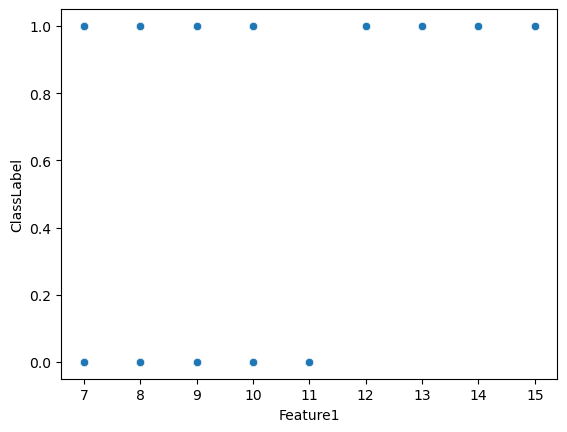

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.scatterplot(data= dataframe, x= "Feature1", y= "ClassLabel")


<AxesSubplot:xlabel='Feature1', ylabel='Feature2'>

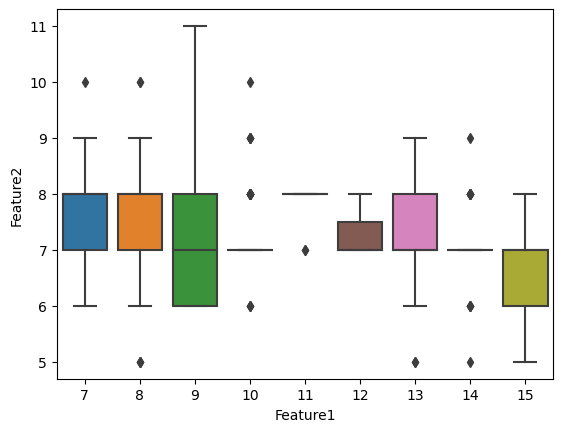

In [54]:
sns.boxplot(data= dataframe, x= "Feature1", y= "Feature2" )

In [ ]:
# pokemon 
pokeX = pd.read_csv('data\pokemonStats.csv')
pokeY = pd.read_csv('data\pokemonLegendary.csv')

pokeData = pokeX.iloc[:, : 7].copy()

pokeAttributes = pokeData.keys()

pokeTree = id3(pokeData, pokeY, pokeAttributes)
